First let us install all the required libraries. I used "folium" here to visualize the locations of the coral on the world map.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
import seaborn as sns
from pathlib import Path
from scipy.stats import linregress
!pip install prophet
!pip install folium

In [142]:

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Relative paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"

# Load data
df_cover = pd.read_csv(f"{DATA_DIR}/CREMP_Pcover_2023_StonyCoralSpecies.csv")
df_density_scor = pd.read_csv(f"{DATA_DIR}/CREMP_SCOR_Summaries_2023_Density.csv")
df_density_octo = pd.read_csv(f"{DATA_DIR}/CREMP_OCTO_Summaries_2023_Density.csv")
df_temp = pd.read_csv(f"{DATA_DIR}/CREMP_Temperatures_2023.csv")
df_taxa = pd.read_csv(f"{DATA_DIR}/CREMP_Pcover_2023_TaxaGroups.csv")

# Basic cleaning
df_cover.columns = df_cover.columns.str.strip()
df_density_scor.columns = df_density_scor.columns.str.strip()
df_density_octo.columns = df_density_octo.columns.str.strip()
df_temp.columns = df_temp.columns.str.strip()


In [5]:
print(df_cover.columns[:8], "...", df_cover.shape)
print(df_density_scor.columns[:8], "...", df_density_scor.shape)
print(df_density_octo.columns, "...", df_density_octo.shape)

Index(['OID_', 'Year', 'Date', 'Subregion', 'Habitat', 'SiteID', 'Site_name',
       'StationID'],
      dtype='object') ... (3918, 50)
Index(['Year', 'Date', 'Subregion', 'Habitat', 'SiteID', 'Site_name',
       'StationID', 'Acropora_cervicornis'],
      dtype='object') ... (2037, 57)
Index(['Year', 'Date', 'Subregion', 'Habitat', 'SiteID', 'Site_name',
       'StationID', 'Eunicea_calyculata', 'Gorgonia_ventalina',
       'Pseudopterogorgia_americana', 'Pseudopterogorgia_bipinnata',
       'Eunicea_flexuosa', 'Pseudoplexaura_porosa', 'Total_Octocorals'],
      dtype='object') ... (1023, 14)


In [19]:
# Show columns 10 onward ,these are all the species
species_cols = df_cover.columns[10:]
print("Species columns:\n", species_cols)


Species columns:
 Index(['Acropora_cervicornis', 'Acropora_palmata', 'Agaricia_fragilis',
       'Agaricia_lamarcki', 'Cladocora_arbuscula', 'Colpophyllia_natans',
       'Dendrogyra_cylindrus', 'Dichocoenia_stokesii',
       'Diploria_labyrinthiformis', 'Eusmilia_fastigiata', 'Favia_fragum',
       'Helioseris_cucullata', 'Isophyllia_rigida', 'Isophyllia_sinuosa',
       'Madracis_aurentenra', 'Madracis_decactis_complex', 'Manicina_areolata',
       'Meandrina_meandrites', 'Millepora_alcicornis', 'Millepora_complanata',
       'Montastraea_cavernosa', 'Mussa_angulosa', 'Mycetophyllia_aliciae',
       'Mycetophyllia_ferox', 'Mycetophyllia_lamarckiana_complex',
       'Oculina_diffusa', 'Oculina_robusta', 'Orbicella_annularis_complex',
       'Phyllangia_americana', 'Porites_astreoides', 'Porites_porites_complex',
       'Pseudodiploria_clivosa', 'Pseudodiploria_strigosa', 'Scleractinia',
       'Scolymia_sp', 'Siderastrea_radians', 'Siderastrea_siderea',
       'Solenastrea_bournoni', 

In [25]:
# Create Total Percent Cover
df_cover['Total_Percent_Cover'] = df_cover[species_cols].sum(axis=1)

# Quick check
print("Total_Percent_Cover column created!", 'Total_Percent_Cover' in df_cover.columns)

Total_Percent_Cover column created! True


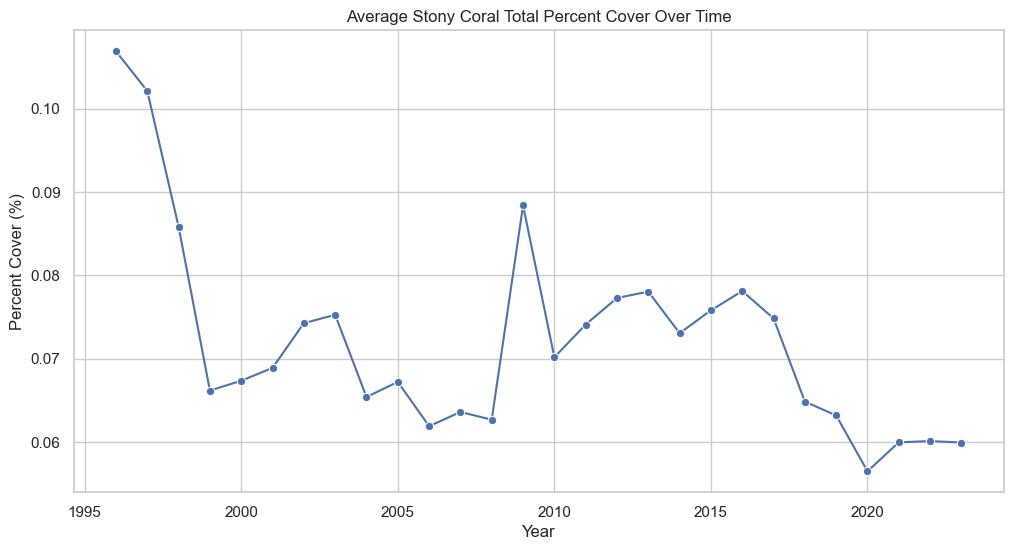

Column added? True


,Year,Site_name,Species_Richness
0,1996,Rattlesnake,0
1,1996,Rattlesnake,0
2,1996,Rattlesnake,0
3,1996,Rattlesnake,0
4,1996,El Radabob,0


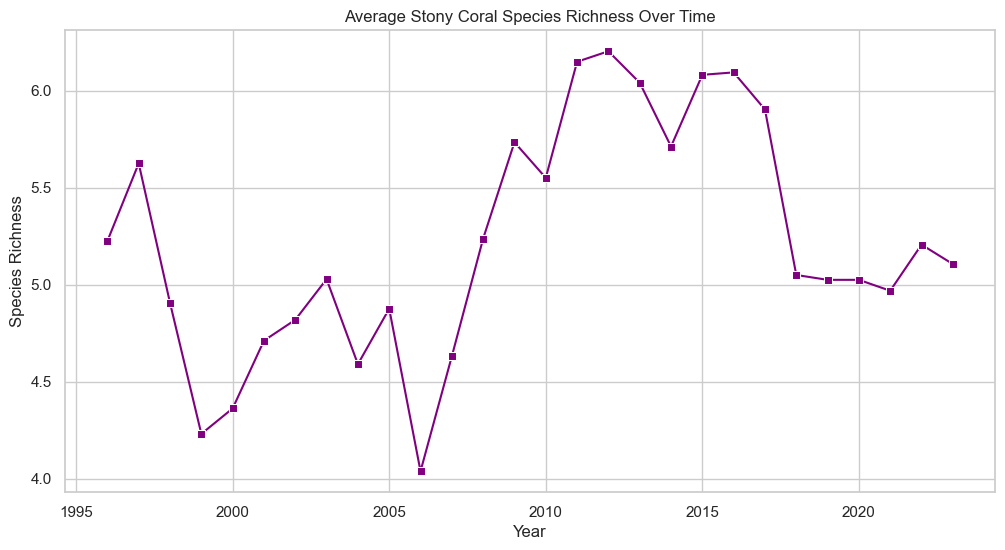

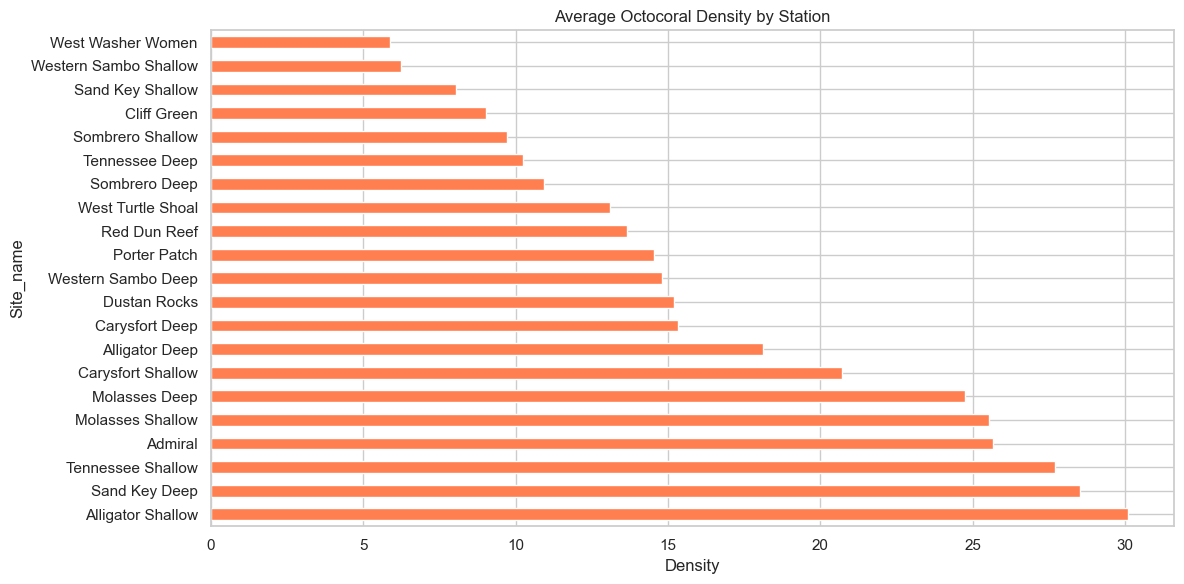

In [27]:
# 1. Exploratory Analysis 


# 1. Total Stony Coral Percent Cover Over Time
cover_by_year = (
    df_cover
    .groupby("Year")["Total_Percent_Cover"]
    .mean()
    .reset_index()
)
sns.lineplot(data=cover_by_year, x="Year", y="Total_Percent_Cover", marker="o")
plt.title("Average Stony Coral Total Percent Cover Over Time")
plt.xlabel("Year")
plt.ylabel("Percent Cover (%)")
plt.savefig("../outputs/stony_coral_cover_trend.png")
plt.show()



# Create the new Species_Richness column
df_cover["Species_Richness"] = (df_cover[species_cols] > 0).sum(axis=1)

# Quick check
print("Column added?", "Species_Richness" in df_cover.columns)
display(df_cover[["Year", "Site_name", "Species_Richness"]].head())

# Group by year, average richness, and plot
richness_by_year = (
    df_cover
    .groupby("Year")["Species_Richness"]
    .mean()
    .reset_index()
)


sns.lineplot(data=richness_by_year, x="Year", y="Species_Richness", marker="s", color="purple")
plt.title("Average Stony Coral Species Richness Over Time")
plt.xlabel("Year")
plt.ylabel("Species Richness")
plt.grid(True)
plt.show()

# Octocoral Density Across Stations
octo_by_station = (
    df_density_octo
    .groupby("Site_name")["Total_Octocorals"]
    .mean()
    .sort_values(ascending=False)
)
octo_by_station.plot(kind="barh", color="coral")
plt.title("Average Octocoral Density by Station")
plt.xlabel("Density")
plt.tight_layout()
plt.savefig("../outputs/octocoral_density_stations.png")
plt.show()


In [29]:
print(df_cover.columns.tolist())


['OID_', 'Year', 'Date', 'Subregion', 'Habitat', 'SiteID', 'Site_name', 'StationID', 'Surveyed_all_years', 'points', 'Acropora_cervicornis', 'Acropora_palmata', 'Agaricia_fragilis', 'Agaricia_lamarcki', 'Cladocora_arbuscula', 'Colpophyllia_natans', 'Dendrogyra_cylindrus', 'Dichocoenia_stokesii', 'Diploria_labyrinthiformis', 'Eusmilia_fastigiata', 'Favia_fragum', 'Helioseris_cucullata', 'Isophyllia_rigida', 'Isophyllia_sinuosa', 'Madracis_aurentenra', 'Madracis_decactis_complex', 'Manicina_areolata', 'Meandrina_meandrites', 'Millepora_alcicornis', 'Millepora_complanata', 'Montastraea_cavernosa', 'Mussa_angulosa', 'Mycetophyllia_aliciae', 'Mycetophyllia_ferox', 'Mycetophyllia_lamarckiana_complex', 'Oculina_diffusa', 'Oculina_robusta', 'Orbicella_annularis_complex', 'Phyllangia_americana', 'Porites_astreoides', 'Porites_porites_complex', 'Pseudodiploria_clivosa', 'Pseudodiploria_strigosa', 'Scleractinia', 'Scolymia_sp', 'Siderastrea_radians', 'Siderastrea_siderea', 'Solenastrea_bournoni',

In [31]:
print(df_density_octo.columns.tolist())

['Year', 'Date', 'Subregion', 'Habitat', 'SiteID', 'Site_name', 'StationID', 'Eunicea_calyculata', 'Gorgonia_ventalina', 'Pseudopterogorgia_americana', 'Pseudopterogorgia_bipinnata', 'Eunicea_flexuosa', 'Pseudoplexaura_porosa', 'Total_Octocorals']


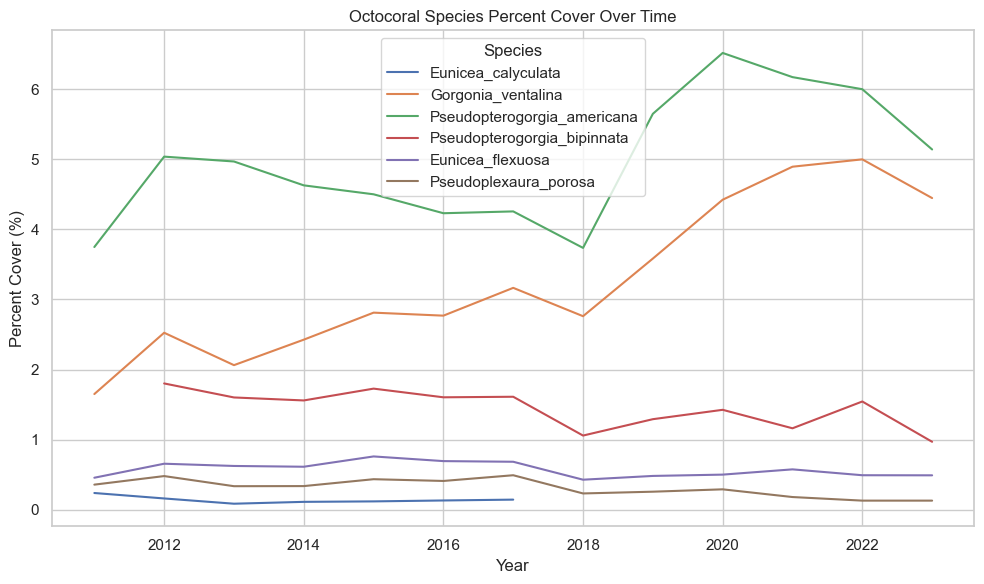

In [33]:
# Octocoral species columns
octo_cols = [
    'Eunicea_calyculata', 'Gorgonia_ventalina', 'Pseudopterogorgia_americana',
    'Pseudopterogorgia_bipinnata', 'Eunicea_flexuosa', 'Pseudoplexaura_porosa'
]

# Plot each octocoral species over time
plt.figure(figsize=(10, 6))

for col in octo_cols:
    avg_per_year = df_density_octo.groupby('Year')[col].mean()
    plt.plot(avg_per_year.index, avg_per_year.values, label=col)

plt.title("Octocoral Species Percent Cover Over Time")
plt.xlabel("Year")
plt.ylabel("Percent Cover (%)")
plt.legend(title="Species")
plt.grid(True)
plt.tight_layout()
plt.show()


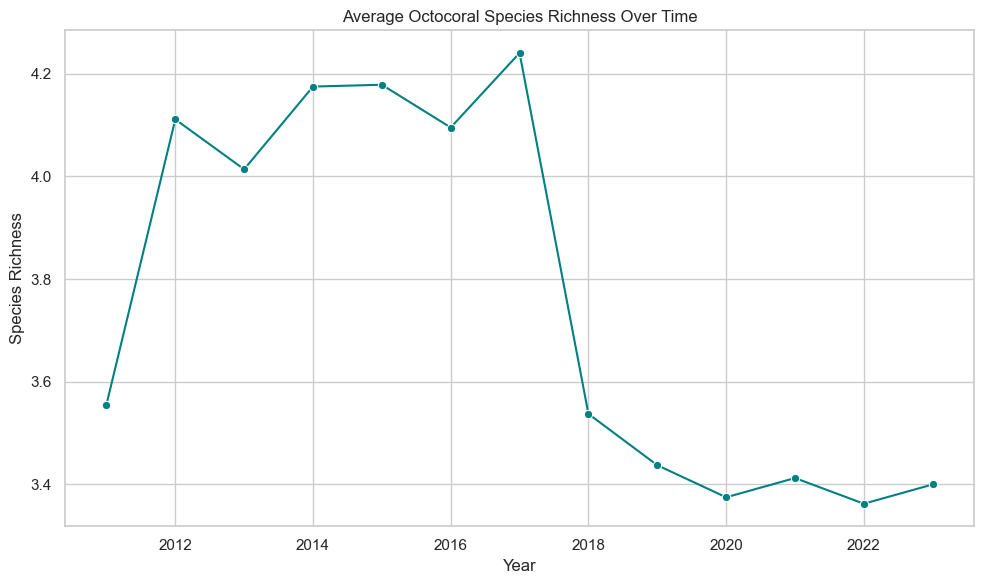

In [35]:
# Create species richness by counting non-zero species in each row
octo_species_cols = [
    'Eunicea_calyculata', 'Gorgonia_ventalina', 'Pseudopterogorgia_americana', 
    'Pseudopterogorgia_bipinnata', 'Eunicea_flexuosa', 'Pseudoplexaura_porosa'
]

# Count non-zero species (species richness) per row (survey)
df_density_octo["Octocoral_Richness"] = (df_density_octo[octo_species_cols] > 0).sum(axis=1)

# Group by Year and get the average richness
richness_by_year = df_density_octo.groupby("Year")["Octocoral_Richness"].mean().reset_index()

# Plot the Octocoral Species Richness Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=richness_by_year, x="Year", y="Octocoral_Richness", marker="o", color="teal")
plt.title("Average Octocoral Species Richness Over Time")
plt.xlabel("Year")
plt.ylabel("Species Richness")
plt.grid(True)
plt.tight_layout()
plt.show()


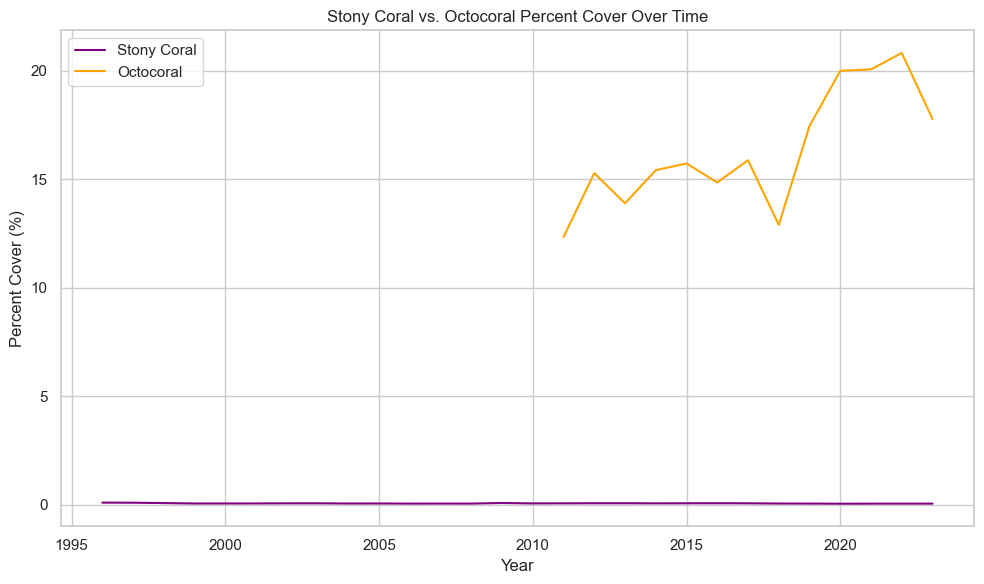

In [37]:
# First, let's calculate average cover for stony corals
stony_avg = df_cover.groupby("Year")["Total_Percent_Cover"].mean()

# Now, calculate average cover for octocorals
octo_avg = df_density_octo.groupby("Year")["Total_Octocorals"].mean()

# Plot both trends on the same graph
plt.figure(figsize=(10, 6))
plt.plot(stony_avg.index, stony_avg.values, label="Stony Coral", color="purple")
plt.plot(octo_avg.index, octo_avg.values, label="Octocoral", color="orange")
plt.title("Stony Coral vs. Octocoral Percent Cover Over Time")
plt.xlabel("Year")
plt.ylabel("Percent Cover (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# Check first few rows of the 'Total_Percent_Cover'
print(df_cover[['Year', 'Total_Percent_Cover']].head())

# Summary statistics to see if values are zero
print(df_cover['Total_Percent_Cover'].describe())


   Year  Total_Percent_Cover
0  1996                  0.0
1  1996                  0.0
2  1996                  0.0
3  1996                  0.0
4  1996                  0.0
count    3918.000000
mean        0.072561
std         0.080724
min         0.000000
25%         0.018500
50%         0.040100
75%         0.097775
max         0.486100
Name: Total_Percent_Cover, dtype: float64


Index(['OID_', 'SiteID', 'Site_name', 'Year', 'Month', 'Day', 'Time', 'TempC',
       'TempF'],
      dtype='object')
   OID_  SiteID    Site_name  Year  Month  Day  Time  TempC  TempF
0     1      10  Rattlesnake  2020      6   12  11.0  29.59  85.26
1     2      10  Rattlesnake  2020      6   12  12.0  29.76  85.57
2     3      10  Rattlesnake  2020      6   12  13.0  29.81  85.66
3     4      10  Rattlesnake  2020      6   12  14.0  30.19  86.34
4     5      10  Rattlesnake  2020      6   12  15.0  30.34  86.61


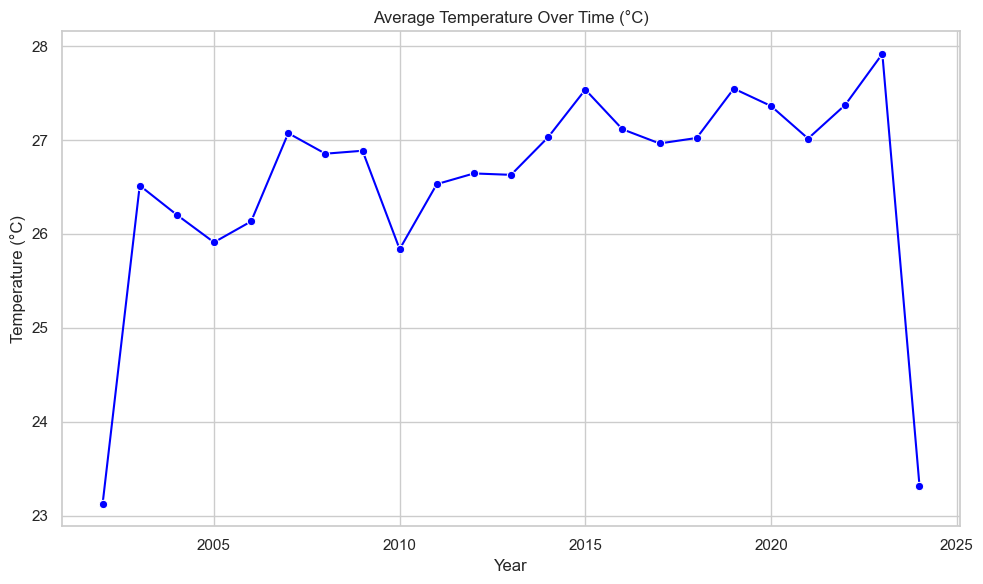

In [41]:
print(df_temp.columns)
print(df_temp.head())
temp_by_year = df_temp.groupby("Year")["TempC"].mean().reset_index()

# Plot the temperature trend over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=temp_by_year, x="Year", y="TempC", marker="o", color="blue")
plt.title("Average Temperature Over Time (°C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

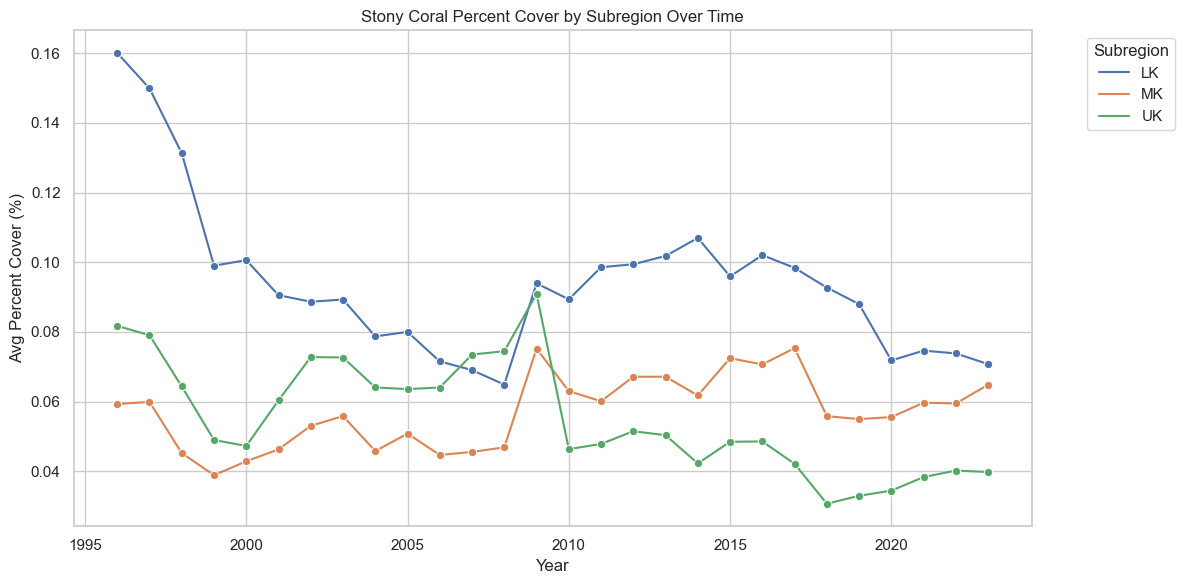

In [43]:
# Calculate average stony coral cover per year per subregion
region_cover = (
    df_cover
    .groupby(["Subregion", "Year"])["Total_Percent_Cover"]
    .mean()
    .reset_index()
)

# Plot: Line plot per subregion
plt.figure(figsize=(12, 6))
sns.lineplot(data=region_cover, x="Year", y="Total_Percent_Cover", hue="Subregion", marker="o")
plt.title("Stony Coral Percent Cover by Subregion Over Time")
plt.xlabel("Year")
plt.ylabel("Avg Percent Cover (%)")
plt.legend(title="Subregion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


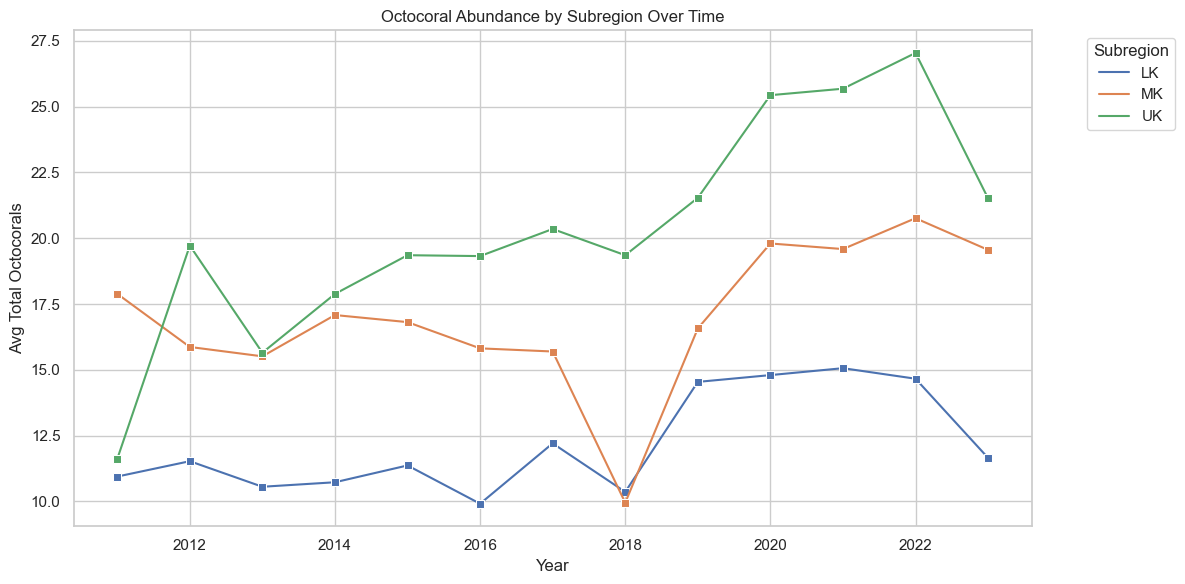

In [45]:
region_octo = (
    df_density_octo
    .groupby(["Subregion", "Year"])["Total_Octocorals"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=region_octo, x="Year", y="Total_Octocorals", hue="Subregion", marker="s")
plt.title("Octocoral Abundance by Subregion Over Time")
plt.xlabel("Year")
plt.ylabel("Avg Total Octocorals")
plt.legend(title="Subregion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


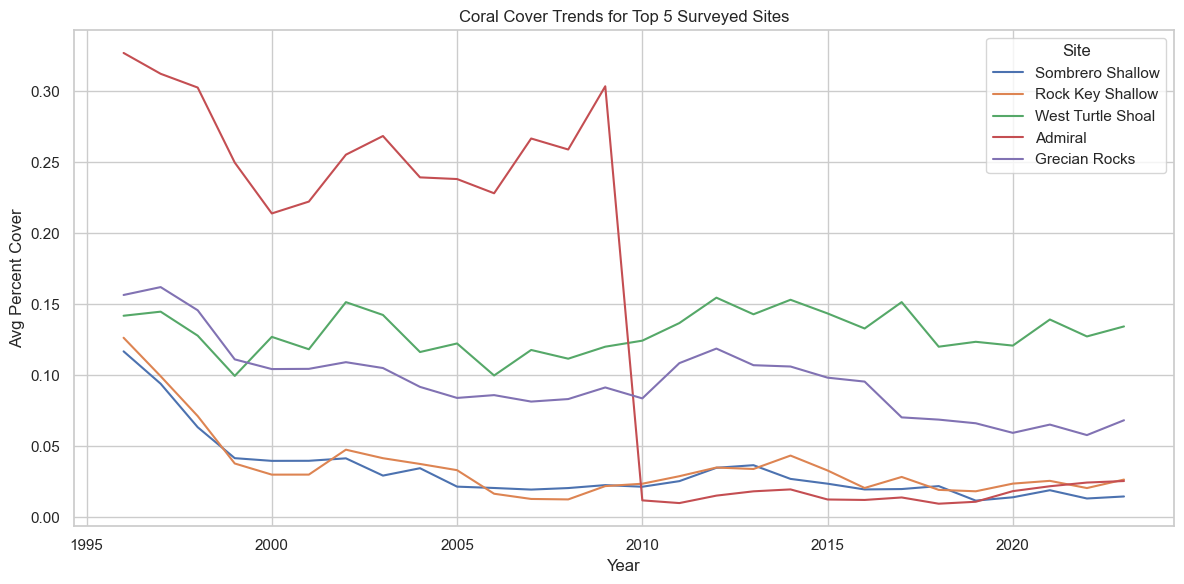

In [47]:
# Step 1: Get top surveyed sites
top_sites = (
    df_cover["Site_name"]
    .value_counts()
    .head(5)
    .index.tolist()
)

# Step 2: Filter & plot for each
plt.figure(figsize=(12, 6))
for site in top_sites:
    site_df = df_cover[df_cover["Site_name"] == site]
    avg_cover = site_df.groupby("Year")["Total_Percent_Cover"].mean()
    plt.plot(avg_cover.index, avg_cover.values, label=site)

plt.title("Coral Cover Trends for Top 5 Surveyed Sites")
plt.xlabel("Year")
plt.ylabel("Avg Percent Cover")
plt.legend(title="Site")
plt.grid(True)
plt.tight_layout()
plt.show()


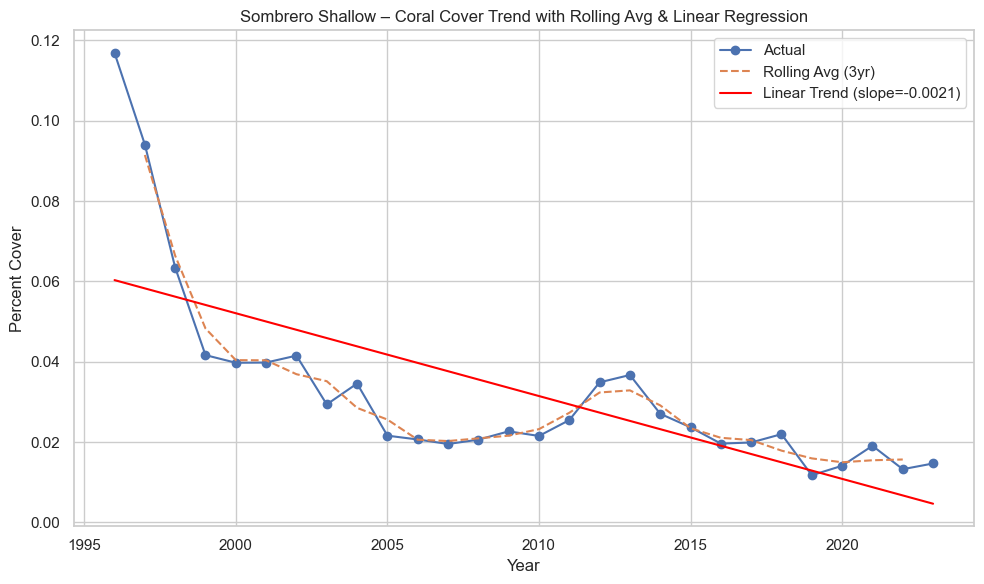

In [49]:

# Example: Pick one site
site = top_sites[0]
site_df = df_cover[df_cover["Site_name"] == site]
cover_by_year = site_df.groupby("Year")["Total_Percent_Cover"].mean().reset_index()

# Rolling average
cover_by_year["Rolling"] = cover_by_year["Total_Percent_Cover"].rolling(window=3, center=True).mean()

# Linear regression
slope, intercept, r_value, p_value, _ = linregress(
    cover_by_year["Year"], cover_by_year["Total_Percent_Cover"]
)
cover_by_year["Trend"] = intercept + slope * cover_by_year["Year"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cover_by_year["Year"], cover_by_year["Total_Percent_Cover"], label="Actual", marker='o')
plt.plot(cover_by_year["Year"], cover_by_year["Rolling"], label="Rolling Avg (3yr)", linestyle="--")
plt.plot(cover_by_year["Year"], cover_by_year["Trend"], label=f"Linear Trend (slope={slope:.4f})", color="red")
plt.title(f"{site} – Coral Cover Trend with Rolling Avg & Linear Regression")
plt.xlabel("Year")
plt.ylabel("Percent Cover")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


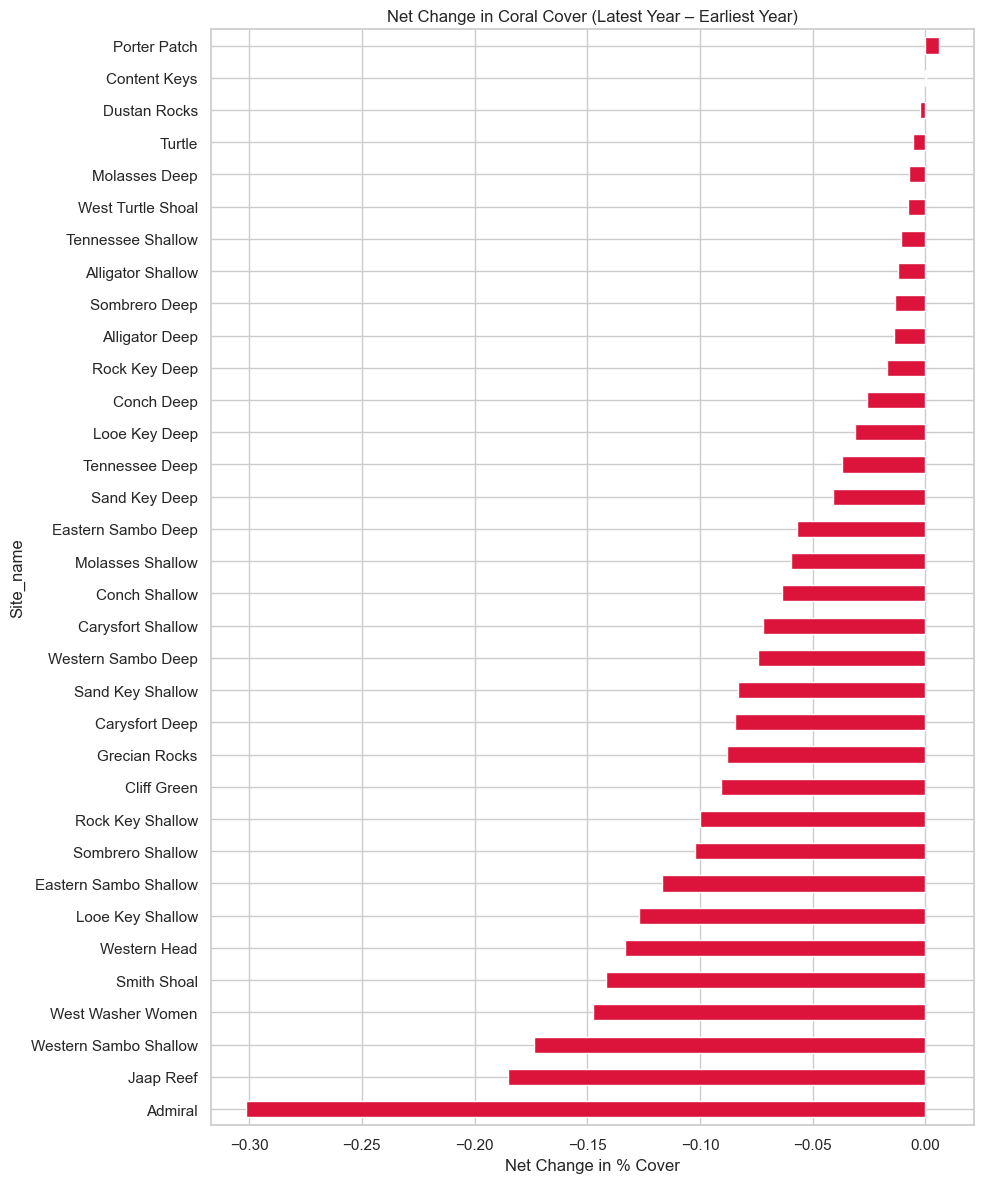

In [51]:
# Net change from earliest to latest year for each site
net_change = (
    df_cover.groupby(["Site_name", "Year"])["Total_Percent_Cover"]
    .mean()
    .reset_index()
    .pivot(index="Site_name", columns="Year", values="Total_Percent_Cover")
)

# Remove sites with missing earliest/latest years
net_change = net_change.dropna(subset=[net_change.columns.min(), net_change.columns.max()])

# Calculate net change
net_change["Net_Change"] = net_change[net_change.columns.max()] - net_change[net_change.columns.min()]
net_change_sorted = net_change["Net_Change"].sort_values()

# Plot
net_change_sorted.plot(kind="barh", figsize=(10, 12), color="crimson")
plt.title("Net Change in Coral Cover (Latest Year – Earliest Year)")
plt.xlabel("Net Change in % Cover")
plt.tight_layout()
plt.show()


In [53]:
# Top 5 decliners
print("🏴 Sites with most decline:")
print(net_change_sorted.head(5))

# Top 5 improvers
print("\n🟢 Sites with most improvement:")
print(net_change_sorted.tail(5))


🏴 Sites with most decline:
Site_name
Admiral                 -0.301475
Jaap Reef               -0.185325
Western Sambo Shallow   -0.173400
West Washer Women       -0.147325
Smith Shoal             -0.141900
Name: Net_Change, dtype: float64

🟢 Sites with most improvement:
Site_name
Molasses Deep   -0.007450
Turtle          -0.005550
Dustan Rocks    -0.002275
Content Keys     0.000250
Porter Patch     0.006150
Name: Net_Change, dtype: float64


In [55]:
# Load station data
df_stations = pd.read_csv("../data/CREMP_Stations_2023.csv")

# Quick check
df_stations[["SiteID", "Site_name", "latDD", "lonDD", "Subregion"]].head()

# Coral cover average per site
site_cover = df_cover.groupby("Site_name")["Total_Percent_Cover"].mean().reset_index()

# Merge cover with coordinates
df_map = pd.merge(df_stations, site_cover, on="Site_name", how="left")

# Drop rows with no location or cover
df_map = df_map.dropna(subset=["latDD", "lonDD", "Total_Percent_Cover"])


from folium.plugins import MarkerCluster

# Create base map
m = folium.Map(location=[24.5, -81.5], zoom_start=7, tiles="CartoDB positron")

# Create clustered marker map
marker_cluster = MarkerCluster().add_to(m)

for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=(row["latDD"], row["lonDD"]),
        radius=5 + row["Total_Percent_Cover"] * 20,  # size based on coral cover
        color="green" if row["Total_Percent_Cover"] > 0.1 else "red",
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(f"{row['Site_name']}<br>{row['Total_Percent_Cover']:.2%}", max_width=300)
    ).add_to(marker_cluster)

m.save("../outputs/coral_cover_map.html")
m


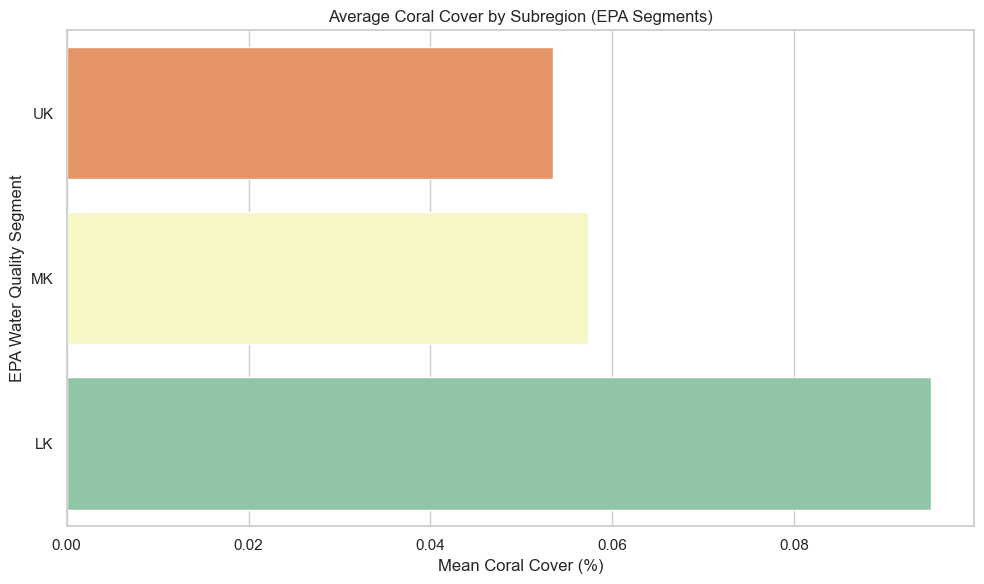

In [57]:
segment_stats = df_cover.groupby("Subregion")["Total_Percent_Cover"].agg(["mean", "count", "std"]).reset_index()
segment_stats = segment_stats.sort_values("mean")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_stats, x="mean", y="Subregion", palette="Spectral")
plt.title("Average Coral Cover by Subregion (EPA Segments)")
plt.xlabel("Mean Coral Cover (%)")
plt.ylabel("EPA Water Quality Segment")
plt.tight_layout()
plt.show()


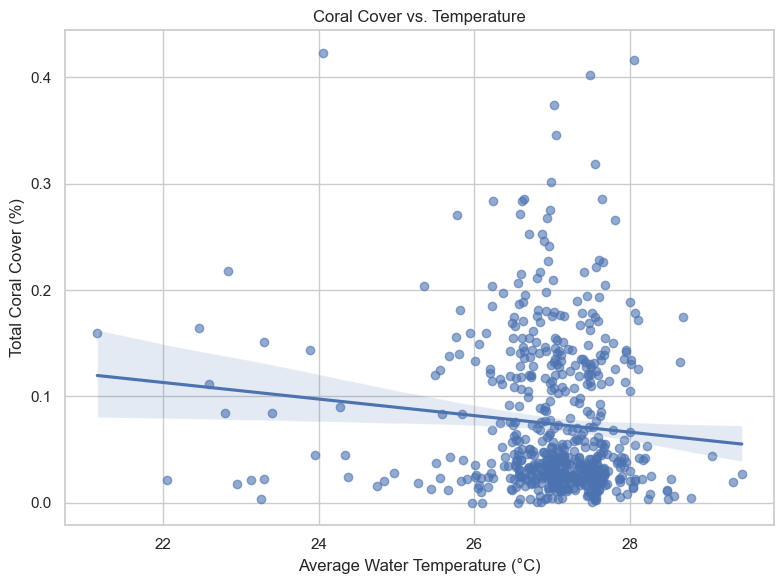

In [59]:
# Average temp per site-year
temp_avg = df_temp.groupby(["Year", "Site_name"])["TempC"].mean().reset_index()
# Average stony coral cover per site-year
cover_avg = df_cover.groupby(["Year", "Site_name"])["Total_Percent_Cover"].mean().reset_index()
# Merge on Year + Site
df_corr = pd.merge(cover_avg, temp_avg, on=["Year", "Site_name"], how="inner")
df_corr.head()



plt.figure(figsize=(8, 6))
sns.regplot(data=df_corr, x="TempC", y="Total_Percent_Cover", scatter_kws={"alpha": 0.6})
plt.title("Coral Cover vs. Temperature")
plt.xlabel("Average Water Temperature (°C)")
plt.ylabel("Total Coral Cover (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from scipy.stats import pearsonr, spearmanr

# Pearson correlation
pearson_corr, p_pearson = pearsonr(df_corr["TempC"], df_corr["Total_Percent_Cover"])
print(f"🔗 Pearson Correlation: {pearson_corr:.3f} (p = {p_pearson:.3g})")

# Spearman (non-linear)
spearman_corr, p_spearman = spearmanr(df_corr["TempC"], df_corr["Total_Percent_Cover"])
print(f"🔗 Spearman Correlation: {spearman_corr:.3f} (p = {p_spearman:.3g})")


🔗 Pearson Correlation: -0.100 (p = 0.016)
🔗 Spearman Correlation: -0.109 (p = 0.00865)


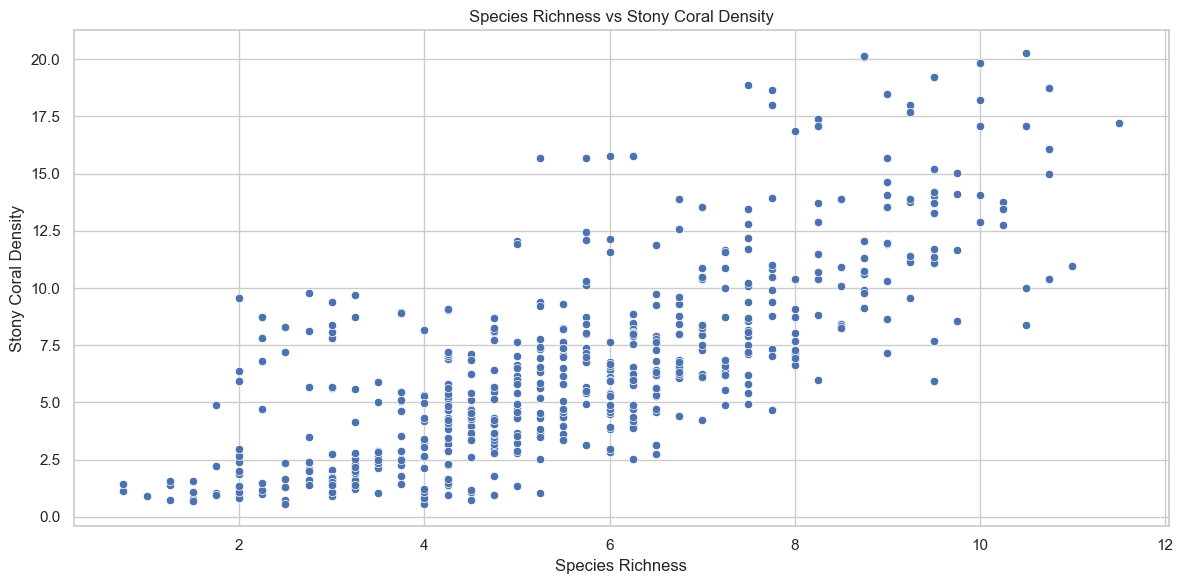

📊 Pearson correlation: 0.743 (p = 0.0000)


In [63]:
# 1. Total stony coral density per row
species_cols = df_density_scor.columns[7:]  # skip metadata
df_density_scor["Stony_Coral_Density"] = df_density_scor[species_cols].sum(axis=1)

# 2. Average density per Year + Site
df_stony_density_avg = (
    df_density_scor
    .groupby(["Year", "Site_name"])["Stony_Coral_Density"]
    .mean()
    .reset_index()
)

# 3. Species richness (already calculated in df_cover)
df_richness = df_cover.groupby(["Year", "Site_name"])["Species_Richness"].mean().reset_index()

# 4. Merge
df_density_rich = pd.merge(df_richness, df_stony_density_avg, on=["Year", "Site_name"], how="inner")

# 5. Plot


from scipy.stats import pearsonr

sns.scatterplot(data=df_density_rich, x="Species_Richness", y="Stony_Coral_Density")
plt.title("Species Richness vs Stony Coral Density")
plt.xlabel("Species Richness")
plt.ylabel("Stony Coral Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Pearson Correlation
r, p = pearsonr(df_density_rich["Species_Richness"], df_density_rich["Stony_Coral_Density"])
print(f"📊 Pearson correlation: {r:.3f} (p = {p:.4f})")


📊 Spearman Correlation: nan (p = nan)


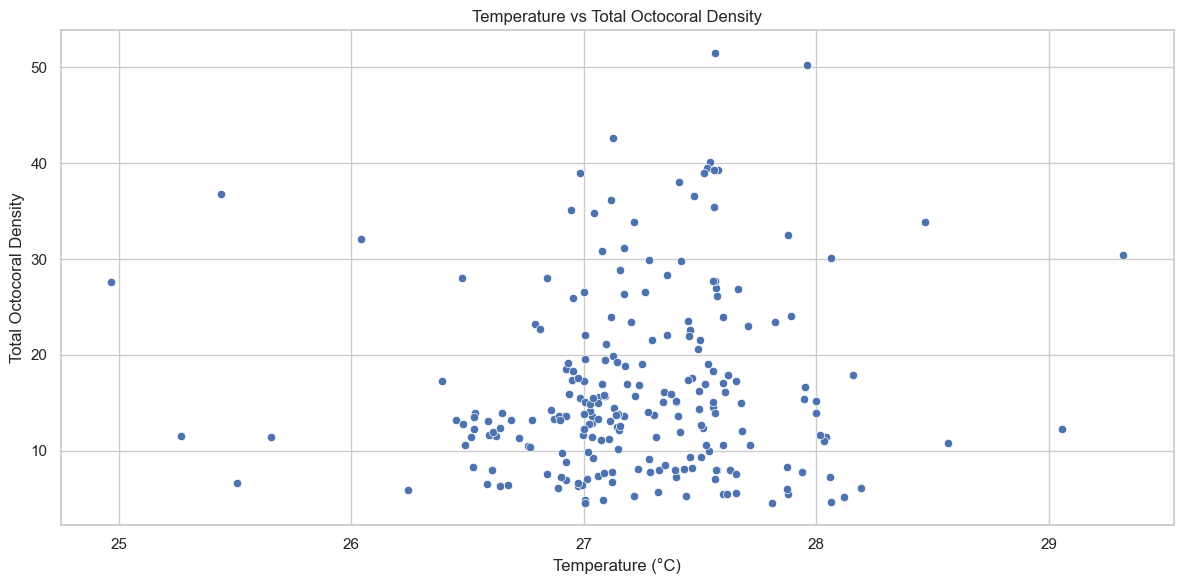

In [65]:
# 1. Average temperature per Year + Site
df_temp_avg = df_temp.groupby(["Year", "Site_name"])["TempC"].mean().reset_index()

# 2. Average total octocoral density per Year + Site
df_octo_avg = df_density_octo.groupby(["Year", "Site_name"])["Total_Octocorals"].mean().reset_index()

# 3. Merge
df_temp_octo = pd.merge(df_temp_avg, df_octo_avg, on=["Year", "Site_name"], how="inner")

# 4. Correlation
from scipy.stats import spearmanr

r, p = spearmanr(df_temp_octo["TempC"], df_temp_octo["Total_Octocorals"])
print(f"📊 Spearman Correlation: {r:.3f} (p = {p:.4f})")

# 5. Plot (optional but great for report)


sns.scatterplot(data=df_temp_octo, x="TempC", y="Total_Octocorals")
plt.title("Temperature vs Total Octocoral Density")
plt.xlabel("Temperature (°C)")
plt.ylabel("Total Octocoral Density")
plt.grid(True)
plt.tight_layout()
plt.show()


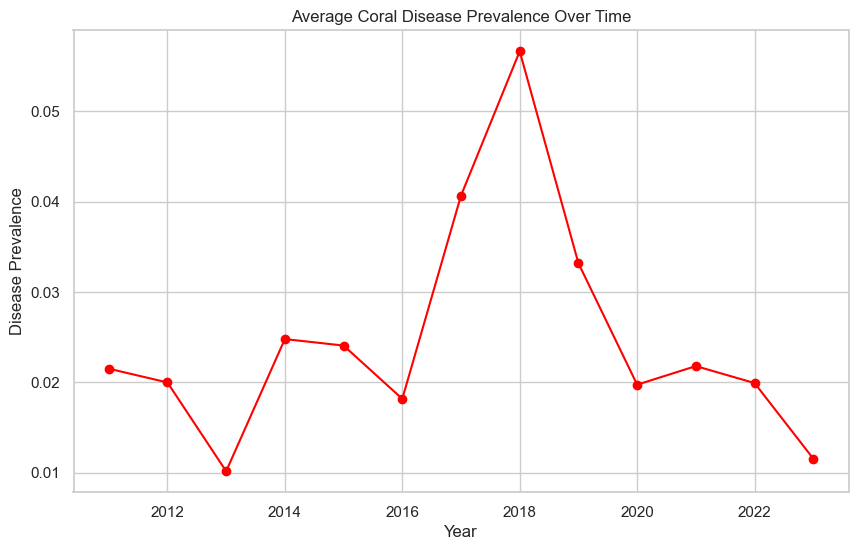

In [67]:
condition_df = pd.read_csv(f"{DATA_DIR}/CREMP_SCOR_Summaries_2023_ConditionCounts.csv")

# Calculate disease prevalence
disease_cols = ['BBD', 'WBD', 'WPX', 'WPL', 'DSD', 'SCT', 'RTL', 'RBD', 'YBD']
condition_df['TotalDiseased'] = condition_df[disease_cols].sum(axis=1)
condition_df['DiseasePrevalence'] = condition_df['TotalDiseased'] / condition_df['Count']

yearly_disease = condition_df.groupby('Year')['DiseasePrevalence'].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(yearly_disease.index, yearly_disease.values, marker='o', color='red')
plt.title('Average Coral Disease Prevalence Over Time')
plt.xlabel('Year')
plt.ylabel('Disease Prevalence')
plt.grid(True)
plt.show()



In [69]:
df_cover.columns

Index(['OID_', 'Year', 'Date', 'Subregion', 'Habitat', 'SiteID', 'Site_name',
       'StationID', 'Surveyed_all_years', 'points', 'Acropora_cervicornis',
       'Acropora_palmata', 'Agaricia_fragilis', 'Agaricia_lamarcki',
       'Cladocora_arbuscula', 'Colpophyllia_natans', 'Dendrogyra_cylindrus',
       'Dichocoenia_stokesii', 'Diploria_labyrinthiformis',
       'Eusmilia_fastigiata', 'Favia_fragum', 'Helioseris_cucullata',
       'Isophyllia_rigida', 'Isophyllia_sinuosa', 'Madracis_aurentenra',
       'Madracis_decactis_complex', 'Manicina_areolata',
       'Meandrina_meandrites', 'Millepora_alcicornis', 'Millepora_complanata',
       'Montastraea_cavernosa', 'Mussa_angulosa', 'Mycetophyllia_aliciae',
       'Mycetophyllia_ferox', 'Mycetophyllia_lamarckiana_complex',
       'Oculina_diffusa', 'Oculina_robusta', 'Orbicella_annularis_complex',
       'Phyllangia_americana', 'Porites_astreoides', 'Porites_porites_complex',
       'Pseudodiploria_clivosa', 'Pseudodiploria_strigosa', 'Sc

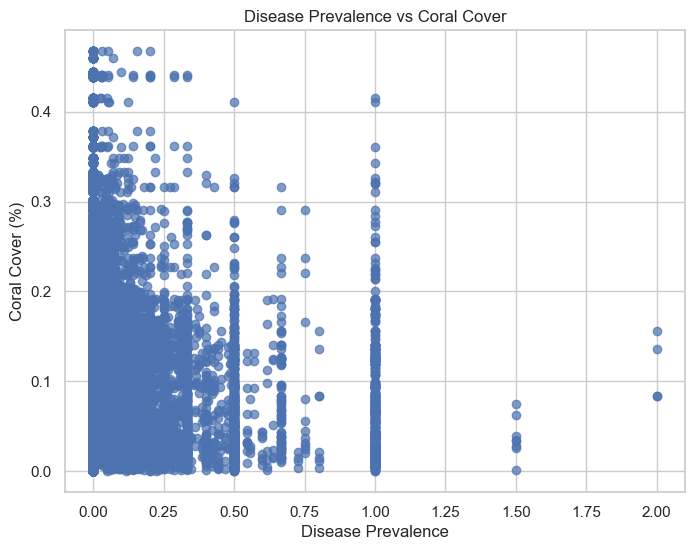

Correlation between disease prevalence and coral cover: 0.01


In [71]:
# Merge condition_df and cover_df on Year and Site
merged_df = pd.merge(condition_df, df_cover, on=['Year', 'SiteID'], how='inner')

# Plot Disease Prevalence vs Coral Cover
plt.figure(figsize=(8,6))
plt.scatter(merged_df['DiseasePrevalence'], merged_df['Total_Percent_Cover'], alpha=0.7)
plt.title('Disease Prevalence vs Coral Cover')
plt.xlabel('Disease Prevalence')
plt.ylabel('Coral Cover (%)')
plt.grid(True)
plt.show()

# (Optional) Calculate correlation
correlation = merged_df['DiseasePrevalence'].corr(merged_df['Total_Percent_Cover'])
print(f'Correlation between disease prevalence and coral cover: {correlation:.2f}')


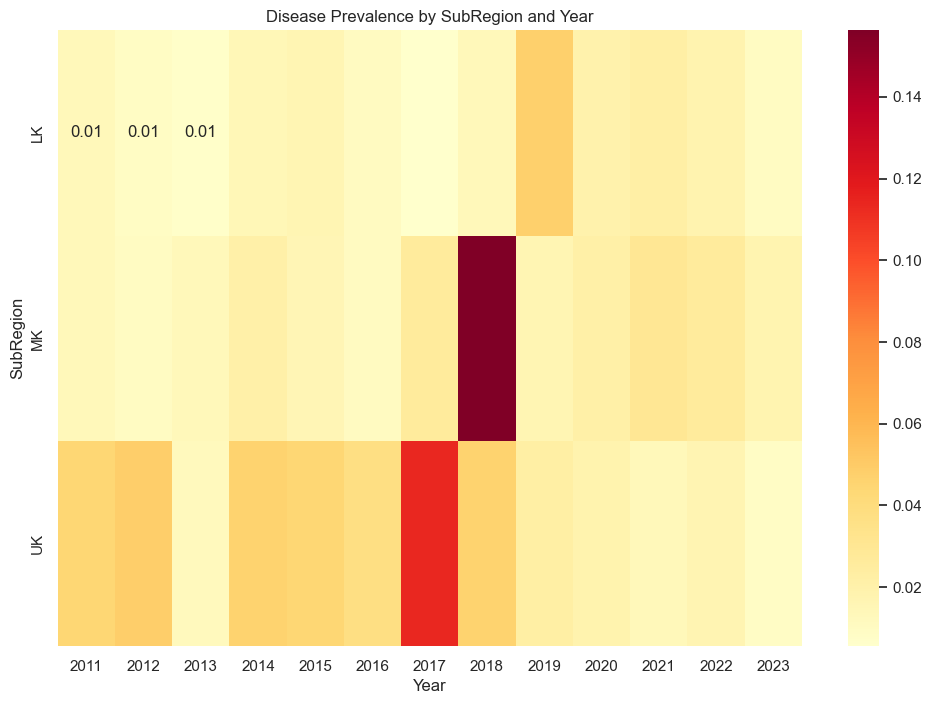

In [73]:
import seaborn as sns

# Group by SubRegion and Year, take mean prevalence
heatmap_data = condition_df.groupby(['Subregion', 'Year'])['DiseasePrevalence'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".2f")
plt.title('Disease Prevalence by SubRegion and Year')
plt.xlabel('Year')
plt.ylabel('SubRegion')
plt.show()


In [75]:
# 1. Feature Engineering
merged_df['BranchingCorals_Percent'] = (
    merged_df['Acropora_cervicornis'] + merged_df['Acropora_palmata'] + merged_df['Millepora_complanata']
) / merged_df['Total_Percent_Cover']

merged_df['MassiveCorals_Percent'] = (
    merged_df['Diploria_labyrinthiformis'] + merged_df['Orbicella_annularis_complex'] + merged_df['Montastraea_cavernosa']
) / merged_df['Total_Percent_Cover']


Test R2: 0.9873
Test MAE: 0.0029
Test RMSE: 0.0087


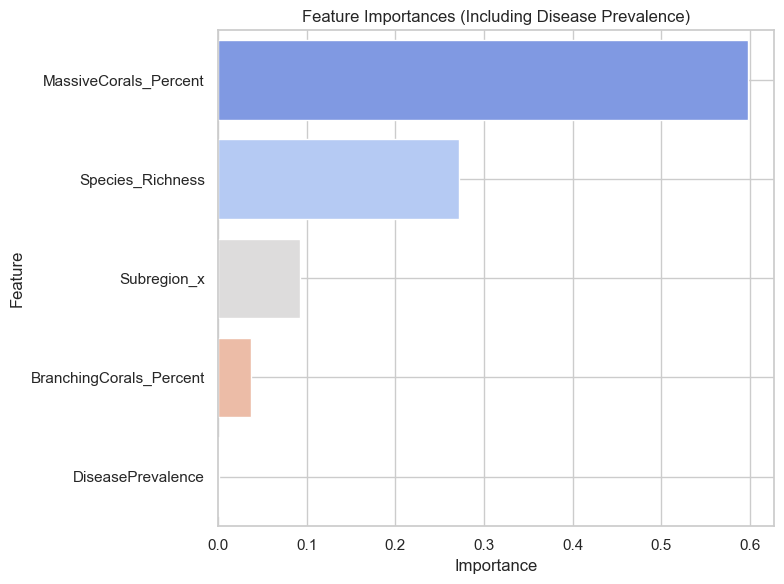

In [97]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged_df['Subregion_x'] = le.fit_transform(merged_df['Subregion_x'])


# 3. Feature Selection
features = [
    'Species_Richness', 'DiseasePrevalence',
    'BranchingCorals_Percent', 'MassiveCorals_Percent',
    'Subregion_x'
]


# Feature and Target selection
X = merged_df[features].fillna(0)  # <-- this will fix your LinearRegression
y = merged_df['Total_Percent_Cover']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 5. Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 6. Model Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred = rf.predict(X_test)

print(f"Test R2: {r2_score(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# 7. Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="coolwarm")
plt.title('Feature Importances (Including Disease Prevalence)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
# Train models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# 2. Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 3. Evaluation Function
def evaluate(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"📊 {model_name} Results:")
    print(f"R² Score       : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-"*40)

# 4. Run Evaluations
evaluate("Linear Regression", y_test, lr_preds)
evaluate("Random Forest", y_test, rf_preds)


📊 Linear Regression Results:
R² Score       : 0.5284
Mean Absolute Error (MAE): 0.0394
Root Mean Squared Error (RMSE): 0.0529
----------------------------------------
📊 Random Forest Results:
R² Score       : 0.9873
Mean Absolute Error (MAE): 0.0029
Root Mean Squared Error (RMSE): 0.0087
----------------------------------------


In [101]:
print(X_train.isnull().sum())


Species_Richness           0
DiseasePrevalence          0
BranchingCorals_Percent    0
MassiveCorals_Percent      0
Subregion_x                0
dtype: int64


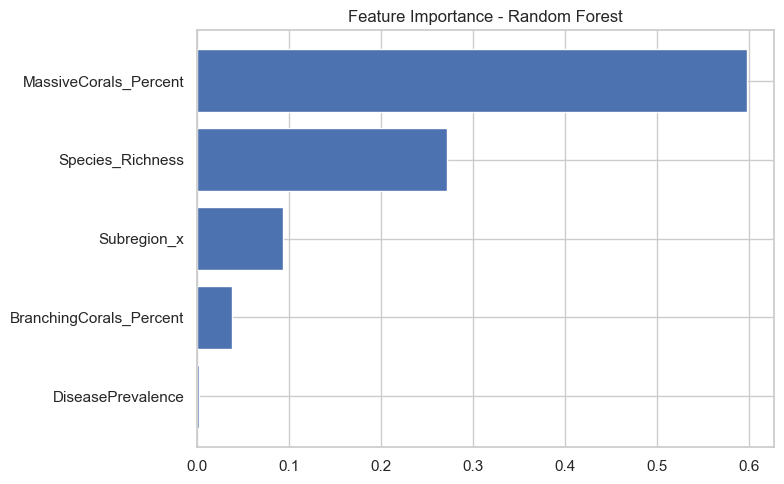

In [103]:

importances = rf.feature_importances_
feat_names = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feat_names[i] for i in sorted_idx])
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


In [156]:
# Use the correct features for RF cross-validation
X_rf = merged_df[[
    "Year", 
    "Species_Richness", 
    "DiseasePrevalence", 
    "BranchingCorals_Percent", 
    "MassiveCorals_Percent", 
    "Subregion_x"
]].fillna(0)
y_rf = merged_df["Total_Percent_Cover"]


# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

rf_cv_scores = cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42),
    X_rf, y_rf,
    cv=5,
    scoring='r2'
)

print(f"Cross-validated R² mean: {rf_cv_scores.mean():.4f}")
print(f"Cross-validated R² std: {rf_cv_scores.std():.4f}")


Cross-validated R² mean: 0.3964
Cross-validated R² std: 0.1527


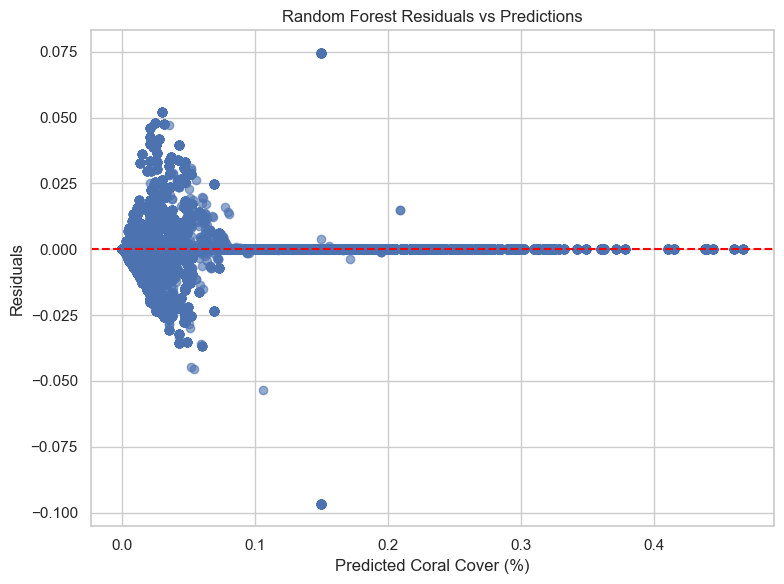

In [113]:
# First, fit RF model properly on full X_rf, y_rf
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)

# Predict on full X_rf
y_rf_pred = rf.predict(X_rf)

# Calculate residuals
residuals = y_rf - y_rf_pred

# Plot residuals vs predicted


plt.figure(figsize=(8,6))
plt.scatter(y_rf_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Random Forest Residuals vs Predictions")
plt.xlabel("Predicted Coral Cover (%)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


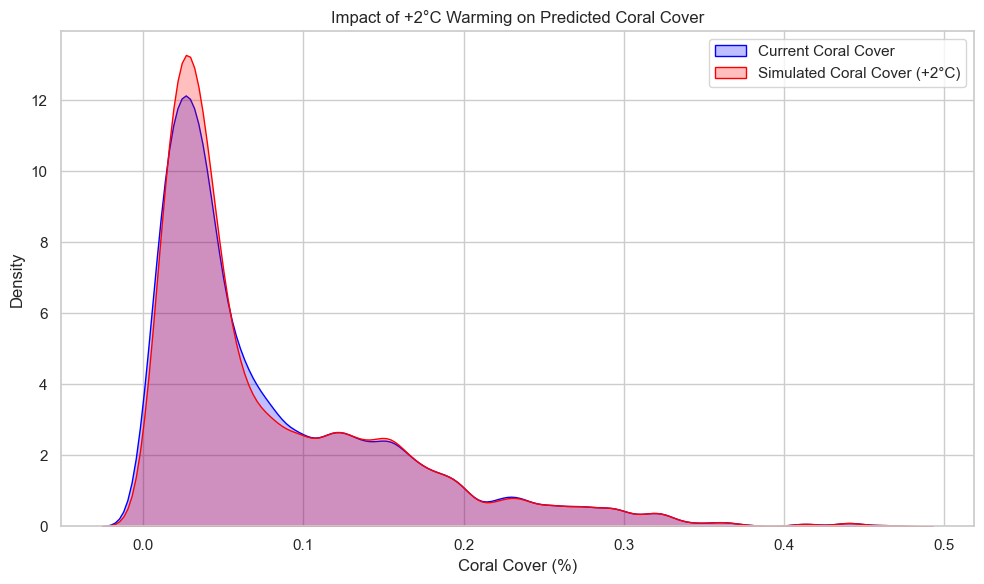

In [125]:
# 1. Create a copy of your input features
X_simulated = X_rf.copy()

# 2. TEMP FIX: Create a fake TempC feature because model wasn't trained on real TempC
X_simulated["TempC"] = 26  # assume average current temperature around 26°C

# 3. Simulate +2°C warming
X_simulated["TempC"] += 2.0

# 4. Drop TempC before prediction (model was trained WITHOUT TempC)
X_simulated = X_simulated.drop(columns=["TempC"])

# 5. Predict coral cover under simulated warming
y_simulated_preds = rf.predict(X_simulated)

# 6. Compare current vs future predicted coral covers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.kdeplot(y_rf, label="Current Coral Cover", fill=True, color="blue")
sns.kdeplot(y_simulated_preds, label="Simulated Coral Cover (+2°C)", fill=True, color="red")

plt.title("Impact of +2°C Warming on Predicted Coral Cover")
plt.xlabel("Coral Cover (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


14:34:17 - cmdstanpy - INFO - Chain [1] start processing
14:34:18 - cmdstanpy - INFO - Chain [1] done processing


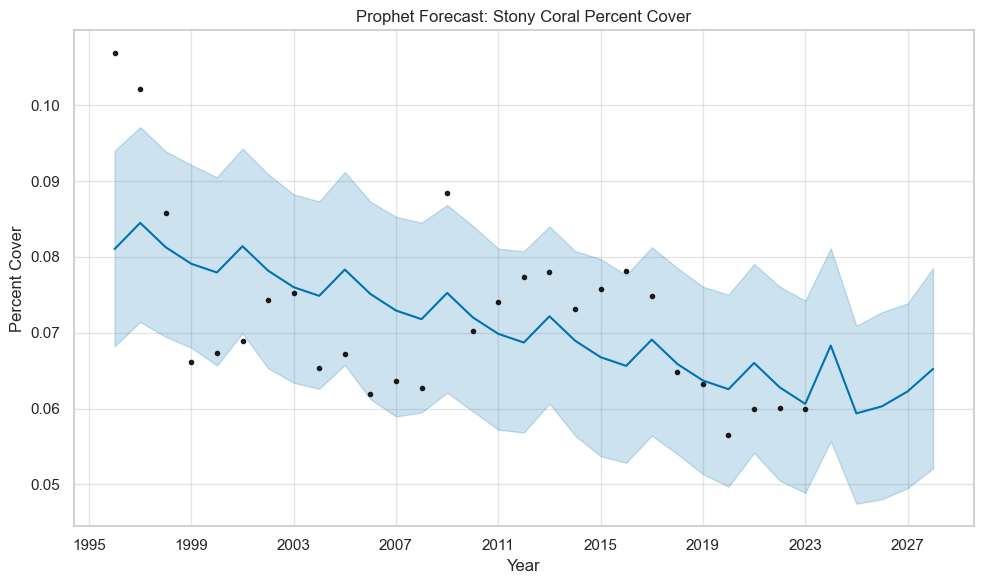

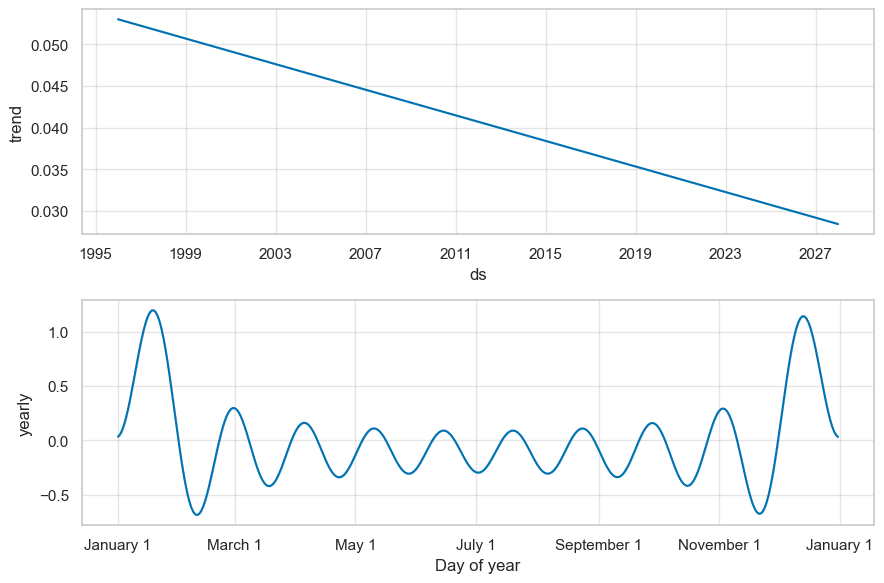

In [129]:
from prophet import Prophet
import pandas as pd

# Prep data
prophet_df = (
    df_cover
    .groupby("Year")["Total_Percent_Cover"]
    .mean()
    .reset_index()
    .rename(columns={"Year": "ds", "Total_Percent_Cover": "y"})
)

# Prophet requires a datetime format
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"], format="%Y")

prophet_df.tail()

#fit prophet
model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast: Stony Coral Percent Cover")
plt.xlabel("Year")
plt.ylabel("Percent Cover")
plt.grid(True)
plt.tight_layout()
plt.show()

model.plot_components(forecast)
plt.tight_layout()
plt.show()



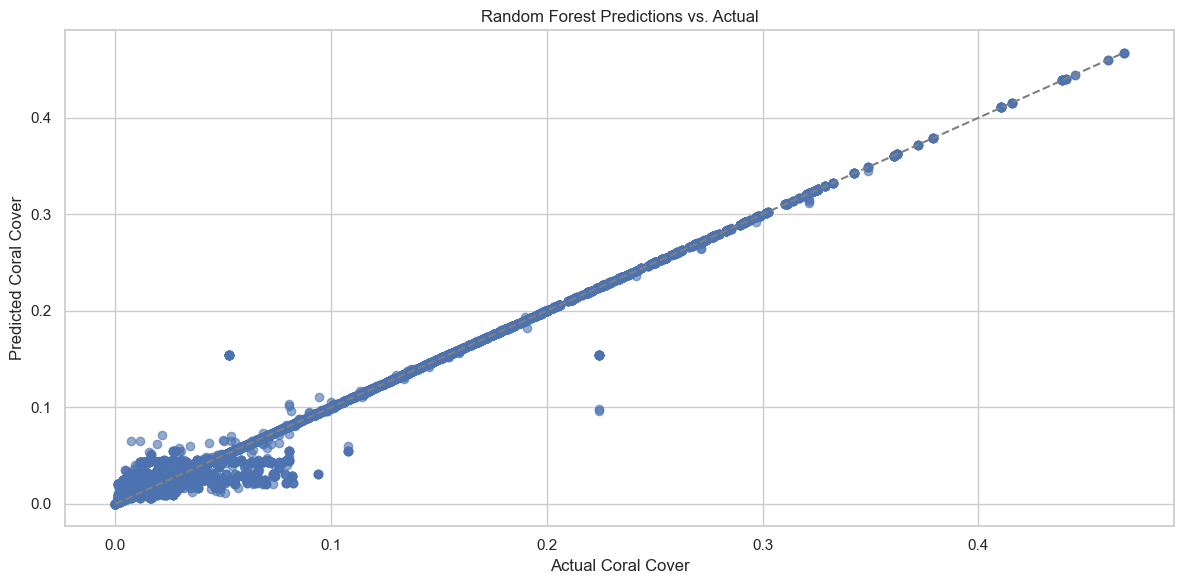

In [131]:
# Plot RF predictions vs actuals
plt.scatter(y_test, rf_preds, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], linestyle="--", color="gray")
plt.xlabel("Actual Coral Cover")
plt.ylabel("Predicted Coral Cover")
plt.title("Random Forest Predictions vs. Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.023447
Epoch 50, Loss: 0.017237
Epoch 100, Loss: 0.016092
Epoch 150, Loss: 0.011111
Epoch 200, Loss: 0.003990
Epoch 250, Loss: 0.003895


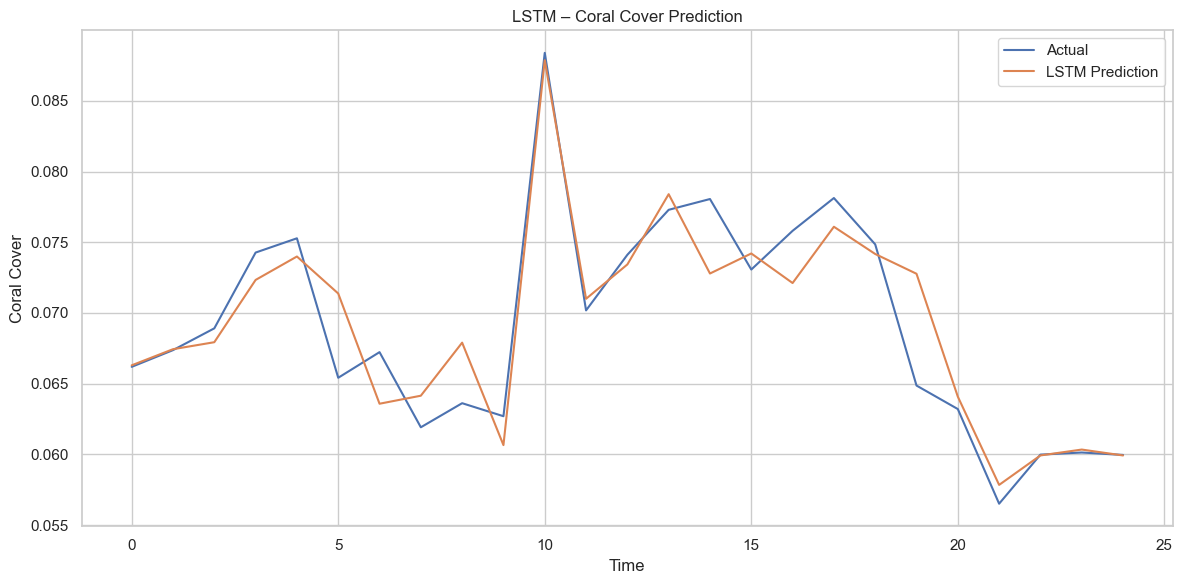

In [133]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Get time series data
series = (
    df_cover
    .groupby("Year")["Total_Percent_Cover"]
    .mean()
    .reset_index()
    .sort_values("Year")
)

values = series["Total_Percent_Cover"].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# Create sequences
def create_sequences(data, seq_len=3):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 3
X, y = create_sequences(scaled, seq_len)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

import torch.nn as nn

class CoralLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super(CoralLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        return self.fc(out)

model = CoralLSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    output = model(X_tensor)
    loss = loss_fn(output, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Predict on training set
model.eval()
with torch.no_grad():
    preds = model(X_tensor).numpy()

# Inverse scale
preds_rescaled = scaler.inverse_transform(preds)
true_rescaled = scaler.inverse_transform(y_tensor.numpy())

# Plot


plt.plot(range(len(true_rescaled)), true_rescaled, label="Actual")
plt.plot(range(len(preds_rescaled)), preds_rescaled, label="LSTM Prediction")
plt.title("LSTM – Coral Cover Prediction")
plt.xlabel("Time")
plt.ylabel("Coral Cover")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\jueej\AppData\Local\Temp\ipykernel_21480\1621280997.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df_taxa.groupby('Year').mean()


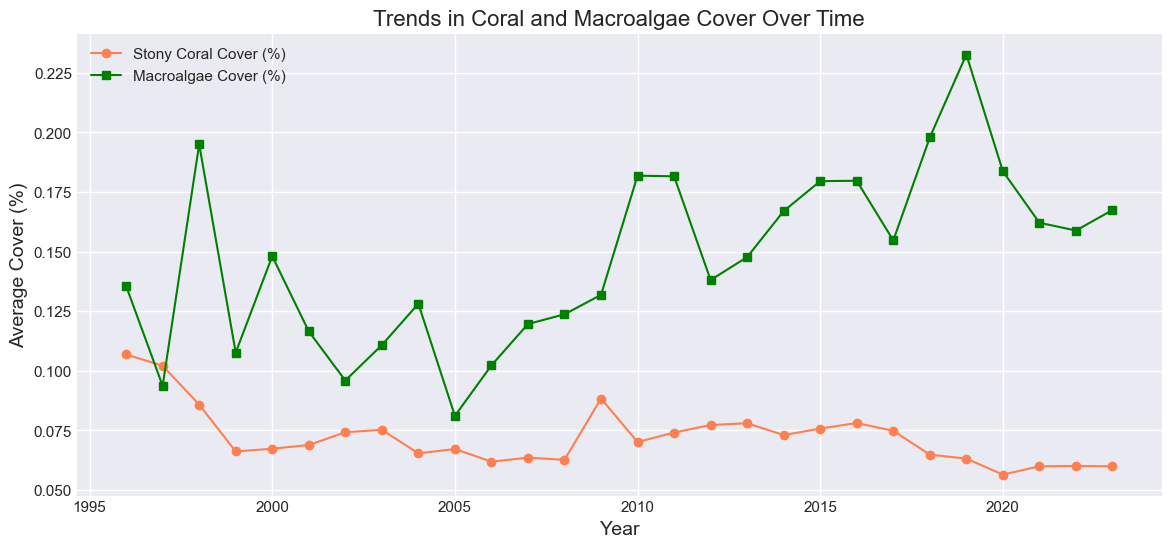

In [146]:
import matplotlib.pyplot as plt

# Group by Year and take mean cover %
grouped = df_taxa.groupby('Year').mean()

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14,6))

# Plot Stony Coral Cover
plt.plot(grouped.index, grouped['Stony_coral'], marker='o', label='Stony Coral Cover (%)', color='coral')

# Plot Macroalgae Cover
plt.plot(grouped.index, grouped['Macroalgae'], marker='s', label='Macroalgae Cover (%)', color='green')

# Labels and Title
plt.title('Trends in Coral and Macroalgae Cover Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Cover (%)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


C:\Users\jueej\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


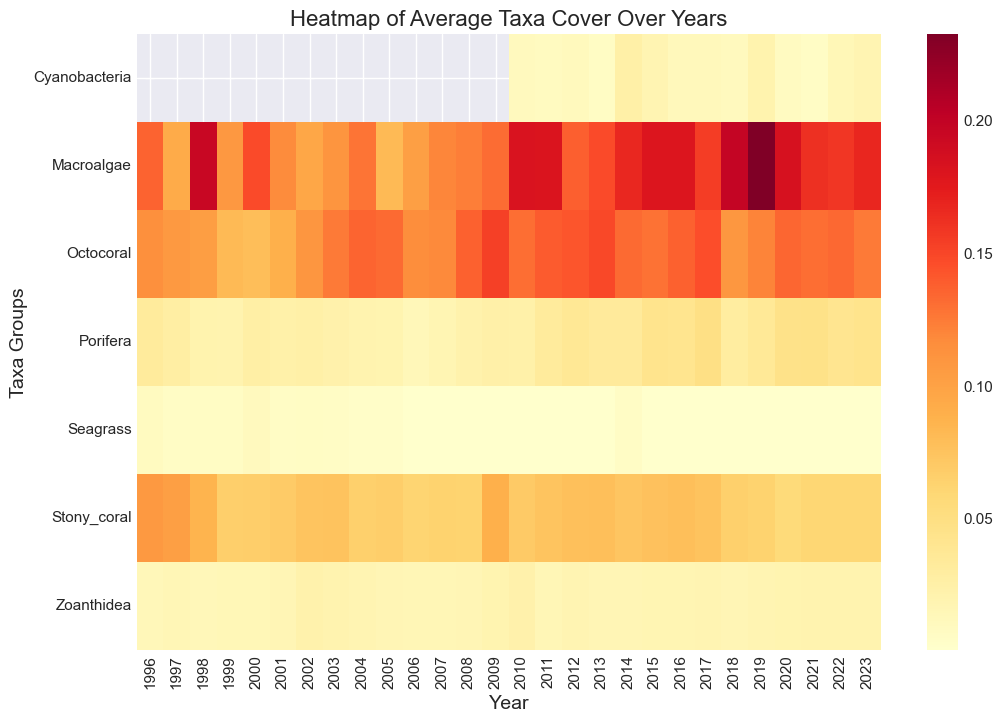

In [150]:
# Pick important taxa columns
taxa_cols = ['Cyanobacteria', 'Macroalgae', 'Octocoral', 'Porifera', 
             'Seagrass', 'Stony_coral', 'Zoanthidea']

# Group and average
heatmap_data = df_taxa.groupby('Year')[taxa_cols].mean()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data.transpose(), cmap='YlOrRd', annot=True, fmt=".1f")
plt.title('Heatmap of Average Taxa Cover Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Taxa Groups', fontsize=14)
plt.yticks(rotation=0)
plt.show()


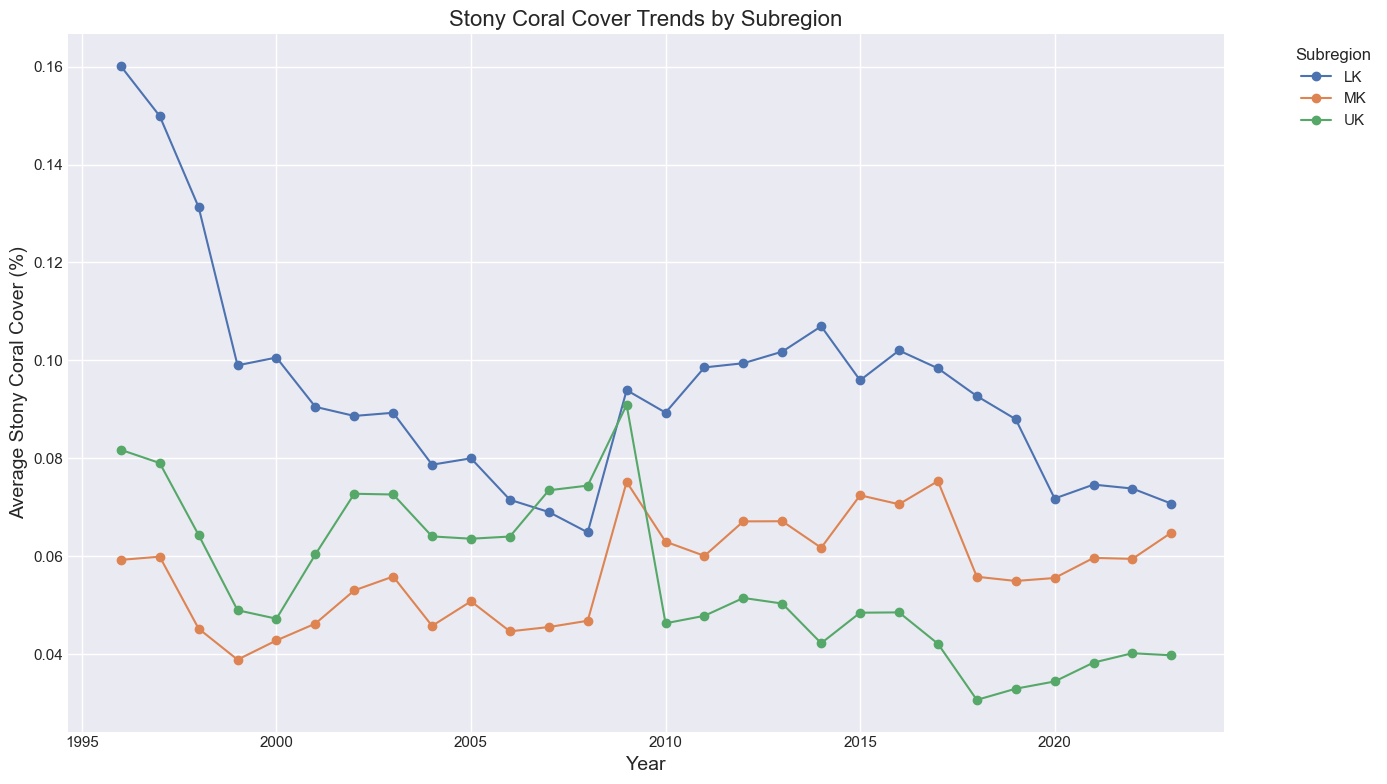

In [154]:
# Group by Year and Subregion
subregion_grouped = df_taxa.groupby(['Year', 'Subregion'])['Stony_coral'].mean().reset_index()

# Pivot the table
pivot_subregion = subregion_grouped.pivot(index='Year', columns='Subregion', values='Stony_coral')

# Plot
pivot_subregion.plot(figsize=(14,8), marker='o')
plt.title('Stony Coral Cover Trends by Subregion', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Stony Coral Cover (%)', fontsize=14)
plt.legend(title='Subregion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Thank you for readung till here! Had fun with this problem statement :D